# Simulation Molecular Traffic Jam

Simulation of traffic jam formation with molecular motors on a microtubule based on the Gillespie algorithm. 

<img src="Fig_model.png" alt="Drawing" style="width: 1000px;"/>

Relevant publications:
* Cho et al. (2008). "Regulatory ATPase sites of cytoplasmic dynein affect processivity and force generation". JBC 283(38): 25839-25845
* Leduc et al. (2012). "Molecular crowding creates traffic jams of kinesin motors on microtubules". PNAS 109(16): 6100-6105
* Parmeggiani et al. (2004). "Totally assymetric simple exclusion process with Langmuir kinetics". Phys Rev Lett 70: 046101



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import sys
import os
from datetime import date, datetime
from timeit import default_timer as timer
from time import strftime
from parameters import ParameterSet
from IPython.display import clear_output

## Define simulation parameters


In [2]:
# Dictionary to store all simulation parameters
simParameters = {}
simParameters['record_data'] = False  # Store data and figures: True or False
simParameters['num_sims'] = 10  # Number of simulations per condition 
simParameters['scan'] = False  # Choice: True (vary lattice size) or False
simParameters['num_scans'] = 3  # Number of lattice sizes to scan
simParameters['type'] = 'SP'  # Determine type of dynein: 'WT' (Wild-Type) or 'SP' (Super-Processive)
simParameters['concentration'] = 1  # Dynein concentration in nM
simParameters['step_size'] = 24  # Basic lattice unit is size of motor step, for dynein the step size is 24 nm
simParameters['length'] = 100  # Length lattice in hopping units
simParameters['length_min'] = 30
simParameters['length_max'] = 300
simParameters['iter_max'] = 50000  # Maximum number of iterations per condition
simParameters['time_max'] = 250  # Max simulated time (in seconds)

# Determine the sampling interval for saving the lattice configuration
# If sampling = 0, then only the last state will be saved. Otherwise, it
# determines the time interval (in seconds) at which to sample the output.
simParameters['sampling'] = 1

## Define characteristics of the molecular motor

Dynein properties are taken from Cho et al. JCB 2008.  

| Dynein | Runlength | Velocity|
| --- | --- | --- |
| Wild type (WT) | 2.25 ± 0.14 $\mu m$ | 73.9 ± 34.2 $nm/sec$ |
| Super processive (SP) | 4.39 ± 0.45 $\mu m$ | 60.6 ± 18.9 $nm/sec$

In [3]:
if simParameters['type'] == 'WT':  # Wild-type dynein
    simParameters['k_on'] = 0.0025  # Attachment rate [/nM/sec]
    simParameters['k_off'] = 73.9/2250  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 73.9/simParameters['step_size']  # Forward hopping rate [sites/sec]        
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]
    
elif simParameters['type'] == 'SP':   # Super processive dynein
    simParameters['k_on'] = 0.0025 #  Attachment rate [/nM/sec]
    simParameters['k_off'] = 60.6/4390  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 60.6/simParameters['step_size']  # Forward hopping rate [sites/sec]  
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]

In [4]:
simPa = ParameterSet(simParameters)

In [5]:
# Set default folder
ROOT  = os.getcwd() 
sys.path.insert(0, ROOT)

# Setup data recording
DATE = str(date.today())
TIME = str(strftime('%X'))
TIME = TIME.replace(':', '-')
    
if simPa.record_data:
    foldername = '.\\SIM_RUNS\\' + DATE + '__' + TIME
    os.makedirs(foldername)

### Function to calculate the propensity of each event

Event 1) Attachment of a particle to an empty spot    
Event 2) Detachment of a particle from an occupied spot   
Event 3) Detachment of a particle from the lattice end  
Event 4) Forward hopping  
 

In [6]:
# Function: Probability of each event
def probability(rates, lattice):
    
    num_events = np.zeros(4)
    position_events = [None]*4
    
    # Empty sites    
    num_events[0] = (lattice == 0).sum()
    position_events[0] = np.nonzero(lattice == 0)[0]
    
    # Occupied sites (excluding lattice end)
    num_events[1] = (lattice[:-1] == 1).sum()
    position_events[1] = np.nonzero(lattice[:-1] == 1)[0]
    
    # Lattice end occupation
    num_events[2] = (lattice[-1] == 1).sum()
    position_events[2] = np.nonzero(lattice[-1] == 1)[0]
    
    # Forward hopping events
    delta_events = np.diff(lattice)
    num_events[3] = (delta_events == -1).sum()    
    position_events[3] = np.nonzero(delta_events == -1)[0]
    
    # Calculate propensities of each event
    propensity = np.multiply(rates, num_events)
        
    return position_events, propensity  

### Function to update lattice state


In [7]:
def update_state(event, selection, state):
    # Update state of lattice    
            
    if event == 0:  # Attachment event   
        index = np.random.randint(len(selection))
        state[selection[index]] += 1             
    elif event == 1:  # Detachment event lattice
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
    elif event == 2:  # Detachment event lattice end
        state[-1] -= 1
    elif event == 3:  # Forward hopping event
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
        state[selection[index] + 1] += 1
    
    return state

### Function to sample the simulated data

In [8]:
def sample_data(lattice, time, simPa):    
    # Sample the simulated data with time steps (in sec) set by simPa.sampling
        
    # Output    
    lattice_sampled = []
    time_sampled = []
            
    if simPa.sampling == 0: # Only save the final state
        lattice_sampled.append(lattice[-1])
        time_sampled.append(time[-1])
    else:
        time_steps = np.arange(1, simPa.time_max) 
        for dt in time_steps:
            ind = np.where(time <= dt)[0][-1]        
            lattice_sampled.append(lattice[ind])
            time_sampled.append(time[ind])
    
    return lattice_sampled, time_sampled

### Function: Gillespie simulation

In [9]:
def gillespie(simPa):            
    # Monte Carlo simulation based on the Gillespie algorithm
    
    # Extract simulation parameters
    rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]

    # Initialize simulation counters
    counter = 0  # simulation iteration
    tt = 0  # time

    # Initialize output containers
    lattice_cont = [np.zeros(simPa.length)]
    tt_cont = np.zeros(1)

    # Draw randum numbers
    rand_nums = np.random.rand(2,simPa.iter_max)

    # Run Gillespie simulation
    while simPa.iter_max > counter and simPa.time_max+1 > tt:
         
        # Calculate probability for all events
        state = lattice_cont[counter]
        [position_events, propensity] = probability(rates, state)

        # Draw waiting time
        delta_t = -np.log(rand_nums[0][counter]) / np.sum(propensity)

        # Construct valid events
        valid_inds = propensity > 0 # Find the possible events
        valid_pp = propensity[valid_inds] # Include only valid events
        valid_changes = np.nonzero(valid_inds)[0]       
        
        # Stop current simulation if no valid changes are possible
        if len(valid_changes) == 0:
            break   

        # Construct intervals
        selection_interval = np.cumsum(valid_pp) # Cumulative sum
        selection_interval = selection_interval/selection_interval[-1] # Normalize to [0,1]

        # Select interval
        selected_ind = np.nonzero(selection_interval > rand_nums[1][counter])[0][0]
        update_ind = position_events[valid_changes[selected_ind]]

        # Update lattice configuration based on chosen interval
        state_new = update_state(valid_changes[selected_ind], update_ind, state)
        lattice_cont = np.vstack((lattice_cont, state_new))

        # Update time and simulation counter
        tt += delta_t
        tt_cont = np.append(tt_cont, tt)
        counter +=1
        
    return lattice_cont, tt_cont              

### Simulate motor protein motion

In [10]:
RESULTS = pd.DataFrame(columns=['Time', 'Lattice','Concentration', 'Length', 'Type', 'Rates', 'Datestamp', 'Timestamp'])
rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]
update = 0        

# Setup parameter scanning
if simPa.scan:    
    simPa.scan_range = np.linspace(simPa.length_min, simPa.length_max, num=simPa.num_scans, dtype=int)
else:
    simPa.scan_range = [simPa.length]
    
for length in simPa.scan_range:    
    simPa.length = length  # Update lattice size     
    for run in range(simPa.num_sims):

        clear_output(wait=True)

        # Call gillespie simulation
        [lattice, time] = gillespie(simPa)    

        # Sample data
        [lattice_sampled, time_sampled] = sample_data(lattice, time, simPa)

        # Store results as pandas.DataFrame
        
        data = {
                'Time': np.asarray(time_sampled), 'Lattice': np.asarray(lattice_sampled), 
                'Concentration': simPa.concentration, 'Length': simPa.length, 'Type': simPa.type,
                'Rates': np.round(rates,4), 'Datestamp': DATE, 'Timestamp': TIME.replace('-', ':')
               }
        RESULTS = RESULTS.append(data, ignore_index=True)                                 

        # Update progress report
        update += 1
        print("Current progress:",np.round(update/(len(simPa.scan_range)*simPa.num_sims) *100, 2),"%")

# Save Data
if simPa.record_data:            
    filename = foldername + '\\' + 'SIM_DYNEIN.data'
       
    with open(filename, 'wb') as filehandle:
        pickle.dump(RESULTS, filehandle)        

### Plot Kymographs

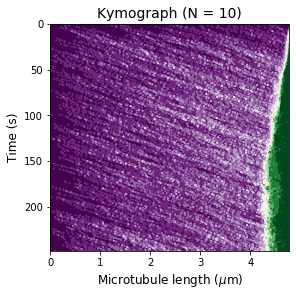

In [12]:
# Number of plots
if simPa.scan:
    rows = int(np.ceil(simPa.num_scans/3))
    cols = simPa.num_scans if simPa.num_scans < 3 else 3 
else:
     rows = cols = 1
        
# Setup figure
fig = plt.figure(constrained_layout=True, figsize=(cols*4 ,rows*4))
spec = fig.add_gridspec(ncols=cols, nrows=rows)

fig_num = 0
for row in range(rows):
    for col in range(cols):         
        if fig_num < len(simPa.scan_range):
            
            # Filter specific lattice size
            filter_length = RESULTS['Length']==simPa.scan_range[fig_num]
            lattice = RESULTS[filter_length].Lattice            

            # Prepare data
            X = np.arange(0, lattice.iloc[0].shape[1])
            X = X * (simPa.step_size/1000) # change units to um
            Y = np.arange(0, lattice.iloc[0].shape[0])
            Y = Y * simPa.sampling # change units to seconds
            X, Y = np.meshgrid(X, Y)
            Z_mean = np.mean(lattice, axis=0)                      
        
            # Plot data
            ax = fig.add_subplot(spec[row, col])     
            ax.contourf(X, Y, Z_mean, 100, cmap='PRGn')    
            ax.set_ylim(Y[-1][0],0)  
            ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=12)
            ax.set_ylabel('Time (s)', fontsize=12)
            
            if simPa.scan:
                ax.set_title('Length = ' + str(np.round(simPa.scan_range[fig_num]*(simPa.step_size/1000),2)) + ' $\mu$m' , fontsize=14)  
            else:
                ax.set_title('Kymograph (N = ' + str(simPa.num_sims) + ')', fontsize=14)
                
            fig_num += 1
        
# Save plot
if simPa.record_data:
    filename = foldername + "/" + 'Figure_1'
    plt.savefig(filename+'.eps', format='eps', dpi=1200)
    plt.savefig(filename+'.png', format='png', dpi=300)
    
plt.show()

In [13]:
# Plot of traffic jam formation

# fig, ax = plt.subplots(figsize = (5,5))

# for num in range(1):
# # for num in range(simPa.nScan):

#     # Prepare data filter            
#     if simPa.Scan is not False:
#         filter_scan = RESULTS[simPa.Scan]==var_param[num]
#         lattice = RESULTS[filter_scan].Lattice
#     else:                      
#         lattice = RESULTS.Lattice  

#     # Prepare data
#     time = np.arange(0, lattice.iloc[0].shape[0])
#     time = time * simPa.sampling # change units to seconds
#     intp = 10
#     Y = np.mean(lattice, axis=0)    
#     L = Y.shape[1]
    
#     for row in range(Y.shape[0]):
#         Y_intp = np.interp(time_intp, time, Y[row,])
#         FWHM[row] = np.where(Y[x,] >= 0.5)[0]
        
#     print(FWHM)
# print(L)
#     FWHM = [np.where(Y[x,] >= 0.5)[0] for x in range(Y.shape[0])]
#     for i in range(len(FWHM)):
#         if FWHM[i].size > 0:
#             FWHM[i] = abs(FWHM[i][0]-Y.shape[1])
#         else:
#             FWHM[i] = 0

    

#     ax.plot(time, FWHM)    

# ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=12)
# ax.set_ylabel('FWHM (nm)' , fontsize=12)
# ax.set_title('Motor density', fontsize = 14)


# # Save plot
# if simPa.record_data:
#     filename = foldername + "/" + 'Figure_3'
#     plt.savefig(filename+'.eps', format='eps', dpi=1200)
#     plt.savefig(filename+'.png', format='png', dpi=300)

# plt.show()

In [14]:
# # MOVE TO ANALYSIS
# # Plot mean distribution of lattice occupation for different concentrations
# if simPa.Scan == 'Length':
    
#     fig, ax = plt.subplots(figsize = (5,5))

#     # Prepare data mean density
#     for num in range(simPa.nScan):

#         #  Prepare data filter
#         if simPa.Scan is not False:
#             filter_scan = SIM_results[simPa.Scan]==var_param[num]
#             lattice = SIM_results[filter_scan].Lattice        
#         else:
#             lattice = SIM_results.Lattice 

#          # Prepare data
#         X = np.arange(0, lattice.iloc[0].shape[1])
#         X = X * (simPa.step/1000) # change units to um
#         Y = np.mean(lattice, axis=0)     

#         ax.plot(X,Y[-1,])

#     ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=13)
#     ax.set_ylabel('Motor density (a.u.)' , fontsize=13)
#     ax.set_title('State @ t=' + str(simPa.T_max) +' sec', fontsize=14)
    
#     if simPa.Scan is 'Length':
#         labels = ['%.0f $\mu$m' %(var_param[x]*(simPa.step/1000)) for x in range(simPa.nScan)]
#         ax.legend(labels, title=simPa.Scan, fontsize='small', loc='upper left')
# #     elif simPa.Scan is 'Concentration':
# #         labels = ['%.2f nM' %var_param[x] for x in range(simPa.nScan)]
# #         ax.legend(labels, title=simPa.Scan, fontsize='small', loc='upper left')     

#     # Save plot
#     if simPa.record_data:
#         filename = foldername + "/" + 'Figure_2'
#         plt.savefig(filename+'.eps', format='eps', dpi=1200)
#         plt.savefig(filename+'.png', format='png', dpi=300)

#     plt.show()